In [ ]:
#default_exp results

In [1]:
#hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Results

> This module contains all the code for running our experiments for Tango.

In [2]:
#hide
import cv2
import pickle
import random
import time

from pathlib import Path

# tango
from tango.prep import *
from tango.features import *
from tango.eval import *
from tango.model import *
from tango.approach import *

from tqdm.auto import tqdm

In [3]:
random.seed(42)
path = Path("/tf/data")

# TODO Need to see if there are app overlaps between the RICO dataset and our validation set and user data

# Data Setup
### Description:
* Number of Participants: 14 (10 students and 4 authors)
* Number of Applications: 6
* Number of Bug Reports per Application: 10

In [4]:
fps = 30

In [5]:
ds_val = 'val'
vid_val_ds = VideoDataset.from_path(path/"datasets/validation_set/", fr = fps).label_from_paths()
vid_val_ds.get_labels()

['car_report', 'king', 'tasty']

In [13]:
vid_val_ds['car_report']

defaultdict(dict,
            {'S0': {'carlos': <tango.prep.Video at 0x7fed227d8ef0>,
              'kevin': <tango.prep.Video at 0x7fee47546550>,
              'nathan': <tango.prep.Video at 0x7fee473c4828>,
              'oscar': <tango.prep.Video at 0x7fed227a11d0>},
             'S1': {'carlos': <tango.prep.Video at 0x7fed22781cc0>,
              'kevin': <tango.prep.Video at 0x7fee473c47f0>,
              'nathan': <tango.prep.Video at 0x7fee475c1ba8>,
              'oscar': <tango.prep.Video at 0x7fed227a1400>},
             'S2': {'carlos': <tango.prep.Video at 0x7fed22773128>,
              'kevin': <tango.prep.Video at 0x7fef0518fa90>,
              'nathan': <tango.prep.Video at 0x7fed227c0b38>,
              'oscar': <tango.prep.Video at 0x7fed227a15c0>},
             'S3': {'carlos': <tango.prep.Video at 0x7fed227736d8>,
              'kevin': <tango.prep.Video at 0x7fed22773160>,
              'nathan': <tango.prep.Video at 0x7fed22773c88>,
              'oscar': <tango.pr

In [15]:
ds_user = 'user'
vid_user_ds = VideoDataset.from_path(path/"datasets/user_data/", fr = fps).label_from_paths()
vid_user_ds.get_labels()

['APOD', 'GROW', 'TIME', 'TOK', 'DROID', 'GNU']

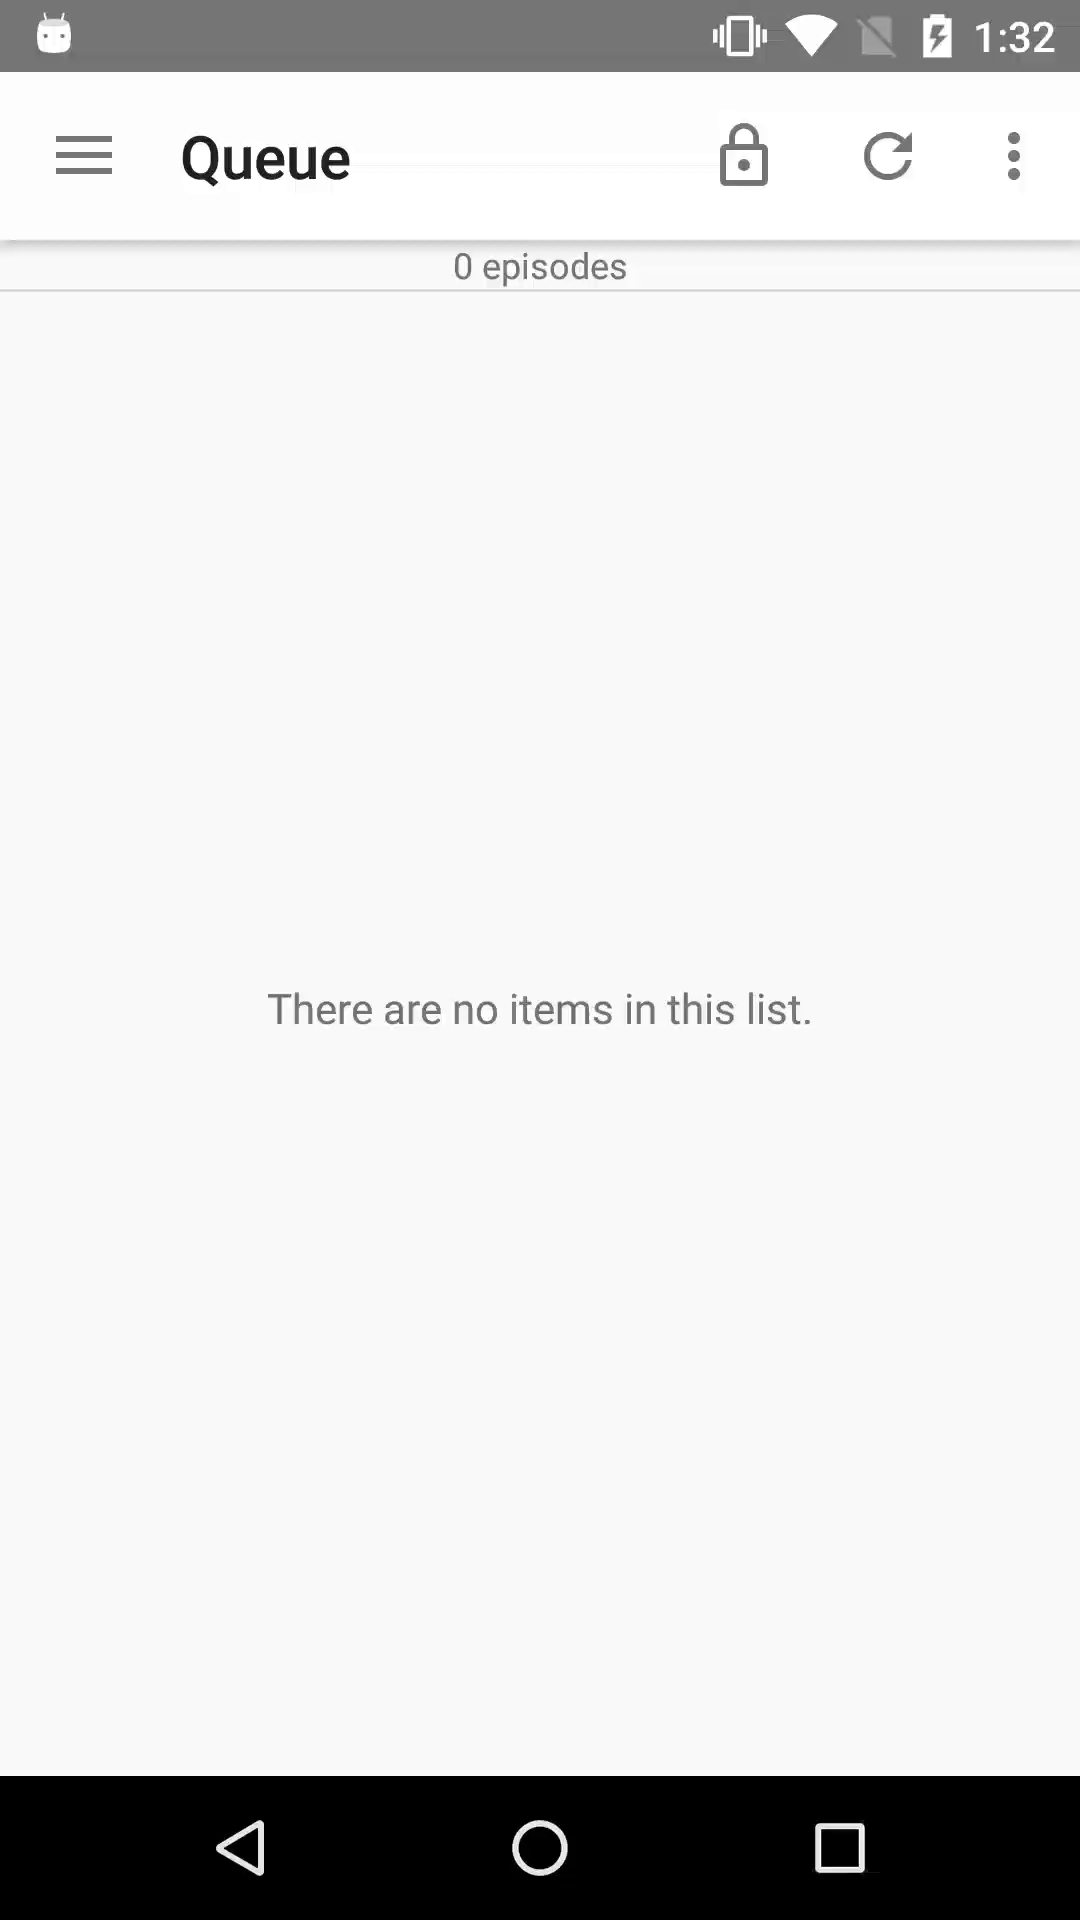

In [21]:
vid_user_ds['APOD']['RB']['Carlos'][0]

In [ ]:
# TODO run evaluation both ways with all videos and then one where some bug reports don't have duplicates

In [ ]:
# TODO look at original fivr paper and bovw papers for finding configuration of models

# Model Setup
### Configurations:
* Number of Visual Words: 1,000, 5,000, 10,000
* Codebook Number of Image Samples: MAX ~50,000
* Number of frames kept: 1, 5
* Model + Bag of Visual Words
* Model + Bag of Visual Words + Fuzzy LCS
* **Potential:** Model + Bag of Visual Words + Fuzzy LCS + Weighting scheme to weight end of video more
* **Potential:** Model + Bag of Visual Words + Fuzzy LCS + Weighting scheme to weight end of video more + V2S selection of important frames (touch indicator appears)

For a total of 12 different configurations per model

# SIFT - M00

In [6]:
model_00 = 'M00'
M00 = SIFTExtractor(cv2.xfeatures2d.SIFT_create(nfeatures = 10)) # limit SIFT features to top 10

# SimCLR - M01

In [7]:
model_01 = 'M01'
simclr = SimCLRModel.load_from_checkpoint(checkpoint_path = str(path/'models/simclr/checkpointepoch=98.ckpt')).eval()
M01 = SimCLRExtractor(simclr)

In [8]:
vwords = [1_000, 5_000, 10_000]
n_imgs = 15_000 # Putting None, means use entire RICO dataset, which is equal to ...
n_frames_to_keep = [1, 5]
models = [(model_00, M00), (model_01, M01)]

In [ ]:
gen_codebooks(path, models, vwords, n_imgs)

In [9]:
def generate_rankings(
    path, vid_ds, ds_name, model_name, model, sim_func, vwords, n_imgs,
     n_frames_to_keep, fps
):

    for vw in tqdm(vwords):
        for ftk in tqdm(n_frames_to_keep):
            evaluation_metrics = {}
            fname = path/f'models/codebooks/{model_name}/cookbook_{model_name}_{vw}vw.model'
            codebook = pickle.load(open(fname, 'rb'))
            start = time.time()
            vid_ds_features = gen_extracted_features(vid_ds, model, fps, ftk)
            end = time.time()
            feature_gen_time = end - start
            df, bovw_vid_ds_sims = gen_bovw_similarity(vid_ds, vid_ds_features, model, codebook, vw, ftk)
            lcs_vid_ds_sims = gen_lcs_similarity(vid_ds, vid_ds_features, sim_func, model, codebook, df, vw, ftk)
            
            rankings = approach(
                vid_ds, vid_ds_features, bovw_vid_ds_sims, lcs_vid_ds_sims, model, sim_func,
                codebook, df, vw, fps = fps, ftk = ftk,
            )
            
            evaluation_metrics['bovw'] = evaluate(
                rankings['bovw']
            )
            evaluation_metrics['lcs'] = evaluate(
                rankings['lcs']
            )
            evaluation_metrics['weighted_lcs'] = evaluate(
                rankings['weighted_lcs']
            )
            
            evaluation_metrics['bovw_lcs'] = evaluate(
                rankings['bovw_lcs']
            )
            evaluation_metrics['bovw_weighted_lcs'] = evaluate(
                rankings['bovw_weighted_lcs']
            )
            
            id_name = f'{ds_name}_{n_imgs}n_{vw}vw_{ftk}ftk'
            with open(path/f'results/{model_name}/{ds_name}/rankings_{id_name}.pkl', 'wb') as f:
                pickle.dump(rankings, f, protocol=pickle.HIGHEST_PROTOCOL)

            with open(path/f'results/{model_name}/{ds_name}/evaluation_metrics_{id_name}.pkl', 'wb') as f:
                pickle.dump(evaluation_metrics, f, protocol=pickle.HIGHEST_PROTOCOL)

# Validation Set

In [ ]:
generate_rankings(
    path, vid_val_ds, ds_val, model_00, M00, sift_frame_sim, vwords, n_imgs,
    n_frames_to_keep, fps
)


car_report Elapsed Time in Seconds 154.1808581352234
car_report σ Rank 1.6093476939431082
car_report μ Rank 1.9
car_report Median Rank 1.0
car_report mRR: 0.7863095238095237
car_report mAP: 0.6589192057942057
car_report Hit@1: 0.7
car_report Hit@5: 0.95
car_report Hit@10: 1.0
king Elapsed Time in Seconds 219.35403895378113
king σ Rank 1.9621416870348585
king μ Rank 2.5
king Median Rank 1.5
king mRR: 0.6546428571428572
king mAP: 0.5519889293999201
king Hit@1: 0.5
king Hit@5: 0.85
king Hit@10: 1.0
tasty Elapsed Time in Seconds 157.05784487724304
tasty σ Rank 1.9615045245933025
tasty μ Rank 1.55
tasty Median Rank 1.0
tasty mRR: 0.905
tasty mAP: 0.8145483193277311
tasty Hit@1: 0.85
tasty Hit@5: 0.95
tasty Hit@10: 1.0
car_report Elapsed Time in Seconds 277.50032353401184
car_report σ Rank 2.0802644062714726
car_report μ Rank 2.35
car_report Median Rank 1.5
car_report mRR: 0.6649999999999999
car_report mAP: 0.5449200209262128
car_report Hit@1: 0.5
car_report Hit@5: 0.95
car_report Hit@10: 1

In [ ]:
generate_rankings(
    path, vid_val_ds, ds_val, model_01, M01, simclr_frame_sim, vwords, n_imgs,
    n_frames_to_keep, fps
)

# User Data

In [ ]:
generate_rankings(
    path, vid_user_ds, ds_user, model_00, M00, sift_frame_sim, vwords, n_imgs,
    n_frames_to_keep, fps
)

In [ ]:
generate_rankings(
    path, vid_user_ds, ds_user, model_01, M01, simclr_frame_sim, vwords, n_imgs,
    n_frames_to_keep, fps
)

# SCRATCH

In [9]:
def generate_rankings(
    path, vid_ds, ds_name, model_name, model, sim_func, vwords, n_imgs,
     n_frames_to_keep, fps
):

    for vw in tqdm(vwords):
        for ftk in tqdm(n_frames_to_keep):
            rankings = {}
            evaluation_metrics = {}
            fname = path/f'models/codebooks/{model_name}/cookbook_{model_name}_{vw}vw.model'
            codebook = pickle.load(open(fname, 'rb'))
            start = time.time()
            vid_ds_features = gen_extracted_features(vid_ds, model, fps, ftk)
            df, bovw_vid_ds_sims = gen_bovw_similarity(vid_ds, vid_ds_features, model, codebook, vw, ftk)
            lcs_vid_ds_sims = gen_lcs_similarity(vid_ds, vid_ds_features, sim_func, mdl, codebook, df, vw, ftk)
            
            
            rankings['bovw'] = approach(
                vid_ds, vid_ds_features, vid_ds_sims, model, sim_func,
                codebook, df, vw, fps = fps, ftk = ftk
            )
            end_bovw = time.time()
            rankings['bovw_time'] = end_bovw - start
            evaluation_metrics['bovw'] = evaluate(
                rankings['bovw']
            )
            
            rankings['lcs'] = approach(
                vid_ds, vid_ds_features, vid_ds_sims, model, sim_func,
                codebook, df, vw, fps = fps, ftk = ftk, mode = 'lcs'
            )
            end_lcs = time.time()
            rankings['lcs_time'] = end_lcs - start
            evaluation_metrics['lcs'] = evaluate(
                rankings['lcs']
            )

#             rankings['bovw_lcs'] = approach(
#                 vid_ds, vid_ds_features, vid_ds_sims, model, sim_func,
#                 codebook, df, vw, fps = fps, ftk = ftk, mode = 'bovw_lcs'
#             )
#             end_bovw_lcs = time.time()
#             rankings['bovw_lcs_time'] = end_bovw_lcs - start
#             evaluation_metrics['bovw_lcs'] = evaluate(
#                 rankings['bovw_lcs']
#             )
            
            id_name = f'{ds_name}_{n_imgs}n_{vw}vw_{ftk}ftk'
            with open(path/f'results/{model_name}/rankings_{id_name}_lcs.pkl', 'wb') as f:
                pickle.dump(rankings, f, protocol=pickle.HIGHEST_PROTOCOL)

            with open(path/f'results/{model_name}/evaluation_metrics_{id_name}_lcs.pkl', 'wb') as f:
                pickle.dump(evaluation_metrics, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
def generate_rankings(
    path, vid_ds, ds_name, model_name, model, sim_func, vwords, n_imgs,
     n_frames_to_keep, fps
):

    for vw in tqdm(vwords):
        for ftk in tqdm(n_frames_to_keep):
            rankings = {}
            evaluation_metrics = {}
            fname = path/f'models/codebooks/{model_name}/cookbook_{model_name}_{vw}vw.model'
            codebook = pickle.load(open(fname, 'rb'))
            start = time.time()
            vid_ds_features = gen_extracted_features(vid_ds, model, fps, ftk)
            df, bovw_vid_ds_sims = gen_bovw_similarity(vid_ds, vid_ds_features, model, codebook, vw, ftk)
            bovw_vid_ds_sims = gen_lcs_similarity(vid_ds, vid_ds_features, sim_func, mdl, codebook, df, vw, ftk)
            
            
            rankings['bovw'] = approach(
                vid_ds, vid_ds_features, vid_ds_sims, model, sim_func,
                codebook, df, vw, fps = fps, ftk = ftk
            )
            rankings_01 = approach(
                vid_ds, vid_ds_features, bovw_vid_ds_sims, lcs_vid_ds_sims, M01, simclr_frame_sim,
                codebook_01, df, vw, fps = fps, ftk = ftk,
            )
            end_bovw = time.time()
            rankings['bovw_time'] = end_bovw - start
            evaluation_metrics['bovw'] = evaluate(
                rankings['bovw']
            )
            
            rankings['lcs'] = approach(
                vid_ds, vid_ds_features, vid_ds_sims, model, sim_func,
                codebook, df, vw, fps = fps, ftk = ftk, mode = 'lcs'
            )
            end_lcs = time.time()
            rankings['lcs_time'] = end_lcs - start
            evaluation_metrics['lcs'] = evaluate(
                rankings['lcs']
            )

#             rankings['bovw_lcs'] = approach(
#                 vid_ds, vid_ds_features, vid_ds_sims, model, sim_func,
#                 codebook, df, vw, fps = fps, ftk = ftk, mode = 'bovw_lcs'
#             )
#             end_bovw_lcs = time.time()
#             rankings['bovw_lcs_time'] = end_bovw_lcs - start
#             evaluation_metrics['bovw_lcs'] = evaluate(
#                 rankings['bovw_lcs']
#             )
            
            id_name = f'{ds_name}_{n_imgs}n_{vw}vw_{ftk}ftk'
            with open(path/f'results/{model_name}/rankings_{id_name}_lcs.pkl', 'wb') as f:
                pickle.dump(rankings, f, protocol=pickle.HIGHEST_PROTOCOL)

            with open(path/f'results/{model_name}/evaluation_metrics_{id_name}_lcs.pkl', 'wb') as f:
                pickle.dump(evaluation_metrics, f, protocol=pickle.HIGHEST_PROTOCOL)

# Scratch

In [ ]:
def generate_rankings(
    path, vid_ds, ds_name, model_name, model, sim_func, vwords, n_imgs,
     n_frames_to_keep, fps
):

    for vw in tqdm(vwords):
        for ftk in tqdm(n_frames_to_keep):
            rankings = {}
            evaluation_metrics = {}
            fname = path/f'models/codebooks/{model_name}/cookbook_{model_name}_{vw}vw.model'
            codebook = pickle.load(open(fname, 'rb'))
            start = time.time()
            vid_ds_features = gen_extracted_features(vid_ds, model, fps, ftk)
            df, bovw_vid_ds_sims = gen_bovw_similarity(vid_ds, vid_ds_features, model, codebook, vw, ftk)
            bovw_vid_ds_sims = gen_lcs_similarity(vid_ds, vid_ds_features, sim_func, mdl, codebook, df, vw, ftk)
            
            
            rankings['bovw'] = approach(
                vid_ds, vid_ds_features, vid_ds_sims, model, sim_func,
                codebook, df, vw, fps = fps, ftk = ftk
            )
            end_bovw = time.time()
            rankings['bovw_time'] = end_bovw - start
            evaluation_metrics['bovw'] = evaluate(
                rankings['bovw']
            )
            
            rankings['lcs'] = approach(
                vid_ds, vid_ds_features, vid_ds_sims, model, sim_func,
                codebook, df, vw, fps = fps, ftk = ftk, mode = 'lcs'
            )
            end_lcs = time.time()
            rankings['lcs_time'] = end_lcs - start
            evaluation_metrics['lcs'] = evaluate(
                rankings['lcs']
            )

#             rankings['bovw_lcs'] = approach(
#                 vid_ds, vid_ds_features, vid_ds_sims, model, sim_func,
#                 codebook, df, vw, fps = fps, ftk = ftk, mode = 'bovw_lcs'
#             )
#             end_bovw_lcs = time.time()
#             rankings['bovw_lcs_time'] = end_bovw_lcs - start
#             evaluation_metrics['bovw_lcs'] = evaluate(
#                 rankings['bovw_lcs']
#             )
            
            id_name = f'{ds_name}_{n_imgs}n_{vw}vw_{ftk}ftk'
            with open(path/f'results/{model_name}/rankings_{id_name}_lcs.pkl', 'wb') as f:
                pickle.dump(rankings, f, protocol=pickle.HIGHEST_PROTOCOL)

            with open(path/f'results/{model_name}/evaluation_metrics_{id_name}_lcs.pkl', 'wb') as f:
                pickle.dump(evaluation_metrics, f, protocol=pickle.HIGHEST_PROTOCOL)

## Setup data

In [ ]:
from random import sample

rico_path = Path('/tf/data/combined/data')
img_paths = sorted(rico_path.glob('*.jpg'))

n = 1_000
sampled_imgs = [Image.open(img) for img in sample(img_paths, n)]
len(sampled_imgs)

In [ ]:
path = Path("/tf/data/datasets/validation_videos")
vid_ds = VideoDataset.from_path(path).label_from_paths()
vid_ds.get_labels()

## Define different models to run experiments on:
- SIFT baseline model - (M01)
- CNN non-layered non-finetuned baseline model - (M02)
- CNN non-layered finetuned baseline model - (M03)
- CNN layered non-finetuned baseline model - (M04)
- CNN layered finetuned baseline model - (M05)

In [ ]:
# SIFT based models:
M00 = SIFTExtractor(cv2.xfeatures2d.SIFT_create())

# CNN based models:
model = SimCLRModel.load_from_checkpoint(checkpoint_path='/tf/data/models/simclr/checkpointepoch=98.ckpt').eval()
M01 = SimCLRExtractor(model)
# M01 = CNNExtractor(createExtractor(None, None, 'resnet50', False))
# learn, linear_output_layer = cnn.trainPetsModel() # Need to change to training on android screenshots
# M02 = CNNExtractor(cnn.createExtractor(learn, linear_output_layer, 'resnet50', True))
# M03 = CNNExtractor(createLayeredExtractor()) # TODO: Rego over implementation as it doesn't seem to generate multiple visual codebooks
# Need to create code for using finetuned layered cnn model M05

models_under_study = [M00, M01] # [M01, M02, M04]

In [ ]:
def gen_all_codebooks(imgs, models, vw):
    for i, model in enumerate(models):
        codebook = gen_vcodebook(imgs, model, vw)
        fname = f'/tf/data/models/cookbook_M{i:02}_{len(imgs)}n_{vw}vw.model'
        pickle.dump(codebook, open(fname, 'wb'))

In [ ]:
vw = 100
gen_all_codebooks(sampled_imgs, models_under_study, vw)

## Experiment 01
Ability for each model to detect duplicate bug report videos.

**TODO:** Need to vary hyperparameters of different values such as number of visual words to include in codebooks

In [ ]:
def gen_tfidfs(vid_ds, mdl, vw, codebook, df, ftk):
#     vid_tfids = results = defaultdict(
#         lambda: defaultdict(list)
#     )
    vid_tfids = defaultdict(
        lambda: defaultdict(list)
    )
    for app, reports in tqdm(vid_ds.labels.items()):
        for i, (report, vids) in enumerate(reports.items()):
            for vid in vids:
                bovw = new_get_bovw(vid, mdl, codebook, vw, frames_to_keep = ftk)
                vid_tfids[app][report].append(calc_tf_idf(bovw, df))
    
    return vid_tfids

In [ ]:
def get_results(vid_ds, imgs, mdls, vw, ftk):
    results = {}
    
    for m, mdl in enumerate(mdls):
        fname = f'/tf/data/models/cookbook_M{m:02}_{len(imgs)}n_{vw}vw.model'
        codebook = pickle.load(open(fname, 'rb'))
        results[f'M{m:02}-{vw}'] = {}
        df = get_df(imgs, mdl, codebook, vw)
        print(df)
        vid_tfids = gen_tfidfs(vid_ds, mdl, vw, codebook, df, ftk)
        for app, reports in vid_ds.labels.items():
            results[f'M{m:02}-{vw}'][app] = {}
            for report_i in reports:
                results[f'M{m:02}-{vw}'][app][report_i] = {}
                for report_j in reports:
                    results[f'M{m:02}-{vw}'][app][report_i][report_j] = {}
                    for k in range(len(vid_tfids[app][report_i])):
                        results[f'M{m:02}-{vw}'][app][report_i][report_j][f'vid_{k}'] = {}
                        for l in range(len(vid_tfids[app][report_j])):
                            results[f'M{m:02}-{vw}'][app][report_i][report_j][f'vid_{k}'][f'vid_{l}'] = np.dot(vid_tfids[app][report_i][k], vid_tfids[app][report_j][l]) / (np.linalg.norm(vid_tfids[app][report_i][k]) * np.linalg.norm(vid_tfids[app][report_j][l]))
    
    return results

In [ ]:
results = get_results(vid_ds, sampled_imgs, models_under_study, vw, 1)

In [ ]:
def flatten_dict(d_in, d_out, parent_key):
    for k, v in d_in.items():
        if isinstance(v, dict):
            flatten_dict(v, d_out, parent_key + (k,))
        else:
            d_out[parent_key + (k,)] = v

In [ ]:
def sort_results(results):
    sorted_results = {}
    for m in results:
        sorted_results[m] = {}
        for app in results[m]:
            sorted_results[m][app] = {}
            d_out = {}
            flatten_dict(results[m][app], d_out, tuple())
            sorted_results[m][app] = OrderedDict(
                sorted(d_out.items(), key=lambda x: x[1], reverse = True)
            )
    
    return sorted_results

In [ ]:
sorted_results = sort_results(results)
pprint(sorted_results['M01-10'])

In [ ]:
evaluate(sorted_results)

In [ ]:
model_codebooks = {}
num_vwords = [100,]
for vwords in tqdm(num_vwords):
    for i, model in tqdm(enumerate(models_under_study), total = len(models_under_study)):
        codebook = gen_vcodebook(imgs, model, vwords)
        model_codebooks[f'M{i + 1:02}-{vwords}'] = codebook

In [ ]:
def gen_tfidfs(vid_ds, df):
    vid_tfids = results = defaultdict(
        lambda: defaultdict(list)
    )
    for app, reports in tqdm(vid_ds.labels.items()):
        for i, (report, vids) in enumerate(reports.items()):
            for vid in vids:
                bovw = new_get_bovw(vid.vid_path, model, codebook, vwords, n = 500)
                vid_tfids[app][report].append(calc_tf_idf(hist, df))
    
    return vid_tfids

In [ ]:
def get_results(vid_ds, imgs, models, model_codebooks, num_vwords):
    results = {}
    
    for vwords in num_vwords:
        for m, (model, (key, codebook)) in enumerate(zip(models, model_codebooks.items())):
            results[f'M{m + 1:02}-{vwords}'] = {}
            df = get_df(imgs, model, codebook, vwords)
            vid_tfids = gen_tfidfs(vid_ds, df)
            for app, reports in vid_ds.labels.items():
                results[f'M{m + 1:02}-{vwords}'][app] = {}
                for report_i in reports:
                    results[f'M{m + 1:02}-{vwords}'][app][report_i] = {}
                    for report_j in reports:
                        results[f'M{m + 1:02}-{vwords}'][app][report_i][report_j] = {}
                        for k in range(len(vid_tfids[app][report_i])):
                            results[f'M{m + 1:02}-{vwords}'][app][report_i][report_j][f'vid_{k}'] = {}
                            for l in range(len(vid_tfids[app][report_j])):
                                results[f'M{m + 1:02}-{vwords}'][app][report_i][report_j][f'vid_{k}'][f'vid_{l}'] = np.dot(vid_tfids[app][report_i][k], vid_tfids[app][report_j][l]) / (np.linalg.norm(vid_tfids[app][report_i][k]) * np.linalg.norm(vid_tfids[app][report_j][l]))
    
    return results

In [ ]:
results = get_results(vid_ds, imgs, models_under_study, model_codebooks, num_vwords)

In [ ]:
def flatten_dict(d_in, d_out, parent_key):
    for k, v in d_in.items():
        if isinstance(v, dict):
            flatten_dict(v, d_out, parent_key + (k,))
        else:
            d_out[parent_key + (k,)] = v

In [ ]:
def sort_results(results):
    sorted_results = {}
    for m in results:
        sorted_results[m] = {}
        for app in results[m]:
            sorted_results[m][app] = {}
            d_out = {}
            flatten_dict(results[m][app], d_out, tuple())
            sorted_results[m][app] = OrderedDict(
                sorted(d_out.items(), key=lambda x: x[1], reverse = True)
            )
    
    return sorted_results

In [ ]:
sorted_results = sort_results(results)
pprint(sorted_results['M01-10'])

In [ ]:
evaluate(sorted_results)

In [ ]:
for model in sorted_results:
    rs = []
    for app in sorted_results[model]:
        r = []
        for labels, score in sorted_results[model][app].items():
            if labels[0] == 'S01':
                if labels[2] != labels[3]:
                    if labels[0] == labels[1]: r.append(1)
                    else: r.append(0)
        rs.append(r)
    
    print(f'{model} mAP:', mean_average_precision(rs))
    print(f'{model} mRR:', mean_reciprocal_rank(rs))

In [ ]:
mean_reciprocal_rank(rs)

In [ ]:
mean_reciprocal_rank(rs)

In [ ]:
mean_average_precision(rs)

In [ ]:
mean_average_precision(rs)

In [ ]:
r1, r2, r3 = [], [], []
for labels, score in sorted_results['M01-100']['car_part'].items():
    if labels[0] == 'S01':
        if labels[2] != labels[3]:
            if labels[0] == labels[1]: r1.append(1)
            else: r1.append(0)

In [ ]:
mean_average_precision([r1, r2, r3])

In [ ]:
average_precision(r1), average_precision(r2), average_precision(r3)

In [ ]:
average_precision(r)

In [ ]:
r2, r3

In [ ]:
for labels, score in sorted_results['M01-100']['car_part'].items():
    if labels[0] == 'S02':
        print(labels)

In [ ]:
sorted_results['M01-100']['car_part']

In [ ]:
# export
def mean_reciprocal_rank(rs):
    """Score is reciprocal of the rank of the first relevant item

    First element is 'rank 1'.  Relevance is binary (nonzero is relevant).

    Example from http://en.wikipedia.org/wiki/Mean_reciprocal_rank
    >>> rs = [[0, 0, 1], [0, 1, 0], [1, 0, 0]]
    >>> mean_reciprocal_rank(rs)
    0.61111111111111105
    >>> rs = np.array([[0, 0, 0], [0, 1, 0], [1, 0, 0]])
    >>> mean_reciprocal_rank(rs)
    0.5
    >>> rs = [[0, 0, 0, 1], [1, 0, 0], [1, 0, 0]]
    >>> mean_reciprocal_rank(rs)
    0.75

    Args:
        rs: Iterator of relevance scores (list or numpy) in rank order
            (first element is the first item)

    Returns:
        Mean reciprocal rank
    """
    rs = (np.asarray(r).nonzero()[0] for r in rs)
    return np.mean([1. / (r[0] + 1) if r.size else 0. for r in rs])

def r_precision(r):
    """Score is precision after all relevant documents have been retrieved

    Relevance is binary (nonzero is relevant).

    >>> r = [0, 0, 1]
    >>> r_precision(r)
    0.33333333333333331
    >>> r = [0, 1, 0]
    >>> r_precision(r)
    0.5
    >>> r = [1, 0, 0]
    >>> r_precision(r)
    1.0

    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)

    Returns:
        R Precision
    """
    r = np.asarray(r) != 0
    z = r.nonzero()[0]
    if not z.size:
        return 0.
    return np.mean(r[:z[-1] + 1])


def precision_at_k(r, k):
    """Score is precision @ k

    Relevance is binary (nonzero is relevant).

    >>> r = [0, 0, 1]
    >>> precision_at_k(r, 1)
    0.0
    >>> precision_at_k(r, 2)
    0.0
    >>> precision_at_k(r, 3)
    0.33333333333333331
    >>> precision_at_k(r, 4)
    Traceback (most recent call last):
        File "<stdin>", line 1, in ?
    ValueError: Relevance score length < k


    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)

    Returns:
        Precision @ k

    Raises:
        ValueError: len(r) must be >= k
    """
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)


def average_precision(r):
    """Score is average precision (area under PR curve)

    Relevance is binary (nonzero is relevant).

    >>> r = [1, 1, 0, 1, 0, 1, 0, 0, 0, 1]
    >>> delta_r = 1. / sum(r)
    >>> sum([sum(r[:x + 1]) / (x + 1.) * delta_r for x, y in enumerate(r) if y])
    0.7833333333333333
    >>> average_precision(r)
    0.78333333333333333

    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)

    Returns:
        Average precision
    """
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)


def mean_average_precision(rs):
    """Score is mean average precision

    Relevance is binary (nonzero is relevant).

    >>> rs = [[1, 1, 0, 1, 0, 1, 0, 0, 0, 1]]
    >>> mean_average_precision(rs)
    0.78333333333333333
    >>> rs = [[1, 1, 0, 1, 0, 1, 0, 0, 0, 1], [0]]
    >>> mean_average_precision(rs)
    0.39166666666666666

    Args:
        rs: Iterator of relevance scores (list or numpy) in rank order
            (first element is the first item)

    Returns:
        Mean average precision
    """
    return np.mean([average_precision(r) for r in rs])


In [ ]:
pd.DataFrame.from_dict(results['M02-100']['car_part']['S01'])

In [ ]:
results['M02-100']['car_part']['S01']

In [ ]:
# TODO Reduce frames per second (try difference numbers)

In [ ]:
# sorted_results = sort_results(results)
pprint(sorted_results['M01-100']['car_part'])

In [ ]:
pprint(sorted_results['M02-100'])

In [ ]:
def get_results(vid_ds, imgs, models, model_codebooks, num_vwords):
    results = defaultdict(
        lambda: defaultdict(
            lambda: defaultdict(
                lambda: defaultdict(
                    lambda: defaultdict(
                        lambda: defaultdict(float)
                    )
                )
            )
        )
    )
    
    for vwords in num_vwords:
        for i, (model, (key, codebook)) in enumerate(zip(models, model_codebooks.items())):
            df = get_df(imgs, model, codebook, vwords)
            for app, reports in vid_ds.labels.items():
                for report_i, vids_i in reports.items():
                    for report_j, vids_j in reports.items():
                        for j, vid_i in enumerate(vids_i):
                            for k, vid_j in enumerate(vids_j):
                                hist_1, bovw_1 = get_bovw(vid_i.vid_path, model, codebook, vwords, n = 100)
                                tf_idf_1 = calc_tf_idf(hist_1, df)
                                hist_2, bovw_2 = get_bovw(vid_j.vid_path, model, codebook, vwords, n = 100)
                                tf_idf_2 = calc_tf_idf(hist_2, df)
                                results[f'M{i + 1:02}-{vwords}'][app][report_i][report_j][f'vid_{j}'][f'vid_{k}'] = np.dot(tf_idf_1, tf_idf_2) / (np.linalg.norm(tf_idf_1) * np.linalg.norm(tf_idf_2))
    
    return results

In [ ]:
results = get_results(vid_ds, imgs, models_under_study, model_codebooks, num_vwords); results

In [ ]:
results['M01-100']['king_james']['S01']

In [ ]:
hist, bovw = get_bovw(vid_ds['king_james']['S01'][0].vid_path, M01, model_codebooks['00-100'], 100, 100)

In [ ]:
#hide
plt.bar(range(vwords), hist)
plt.show()

In [6]:
path2 = Path("/tf/data/results")
model_name = 'M01'
fname = path2/f'{model_name}/val/rankings_val_15000n_10000vw_5ftk.pkl'
rankings = pickle.load(open(fname, 'rb'))